In [1]:

import tensorflow as tf
import pandas as ad
import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [3]:
unet = tf.keras.models.load_model('model.h5', compile=False)

image_gray = np.load("D:/fin_de_etude/data/dataset_2d/nodule/image179_slice265.npy")
image_gray = image_gray/255
y_1 = unet.predict(image_gray.reshape((1,512,512,1)))
y_1 = np.where(y_1>0.5,1,0)


1/1 [==============================] - 8s 8s/step


In [4]:
deeplab = tf.keras.models.load_model('deeplabv3plus.h5', compile=False)

y_2 = deeplab.predict(image_gray.reshape((1,512,512,1)))
y_2 = np.where(y_1>0.5,1,0)



1/1 [==============================] - 2s 2s/step


In [5]:
print(image_gray.max())

1.0


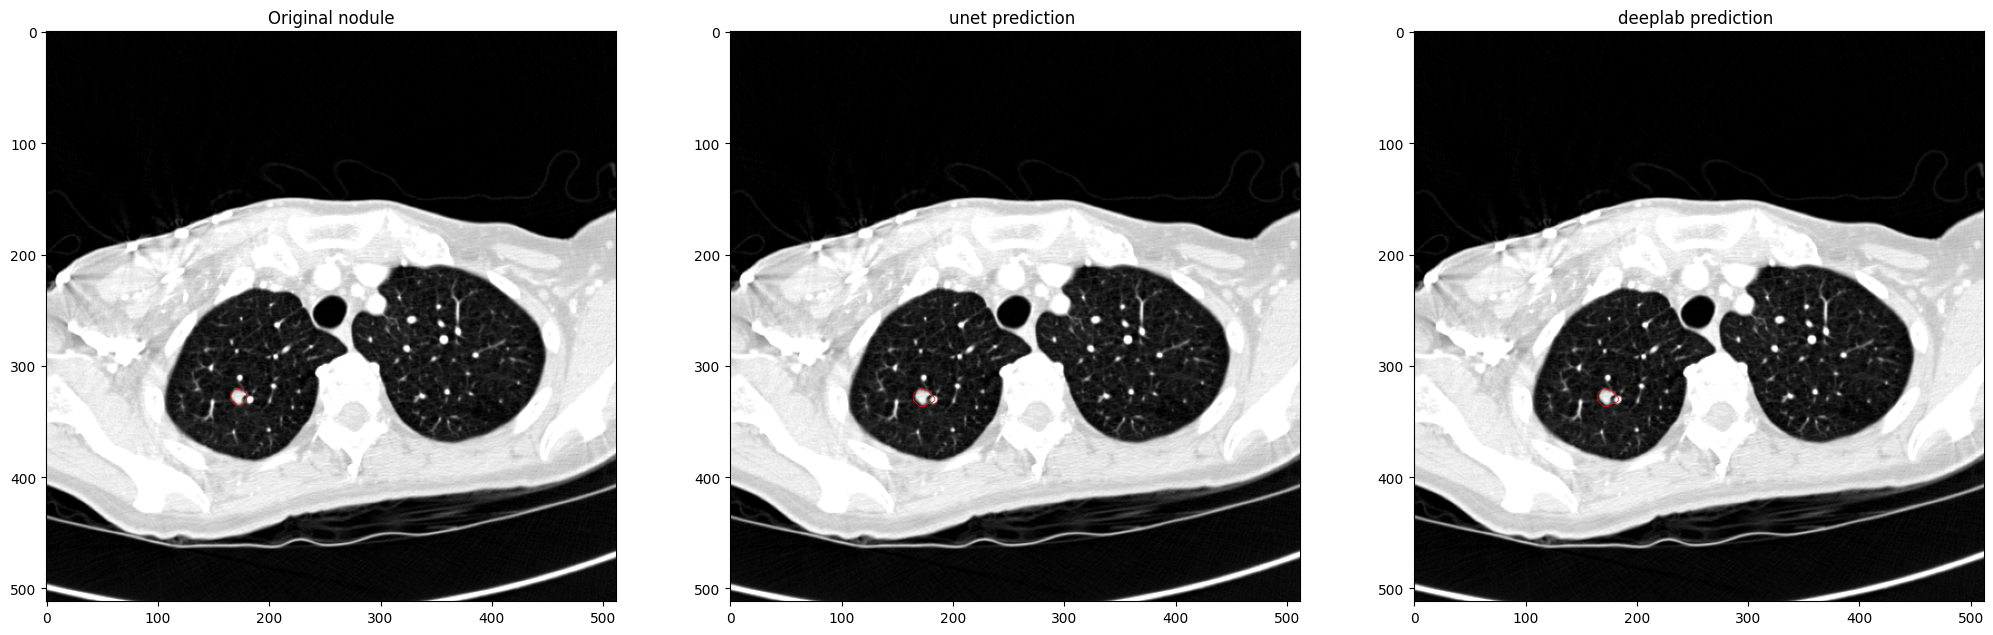

In [6]:
image_gray = image_gray*255
mask = np.load("D:/fin_de_etude/data/nodule_mask/nodule/image179_slice265.npy")
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(25, 25))
ax1.imshow(image_gray,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(image_gray,cmap='gray')
ax2.set_title('unet prediction ')
ax3.imshow(image_gray,cmap='gray')
ax3.set_title('deeplab prediction ')
ax1.contour(mask.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)
ax3.contour(y_2.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)

plt.show()

In [7]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad

  
# take the first contour
# Find contours in the mask
contours = measure.find_contours(mask, 0.85
                                 )

# Loop through the contours and extract the circle properties
for cnt in contours:
    # Convert the contour to integer format
    cnt = np.array(cnt,dtype=np.float32)

    # Fit a circle to the contour using the minimum enclosing circle method
    (y, x), radius = cv2.minEnclosingCircle(cnt)
    center = (x,y)
    diameter = radius*2
    
    # Print the circle properties
    
    print('Center:', center)
    print('Diameter:', diameter)

Center: (172.5, 328.0)
Diameter: 14.611485481262207


In [8]:
df = ad.read_csv("D:/fin_de_etude/data/pfe/data preprocessing/annotation_2.csv")
df = df[df["seriesuid"]=="image179_slice265"]
x,y,z,d = np.double(df["coordX"]),float(df["coordY"]),float(df["coordZ"]),float(df["diameter_mm"])
print(x,y,z,d)
print(df)

172.5271898722807 328.07880172238595 265.0 14.629298181389474
   Unnamed: 0          seriesuid     coordX      coordY  coordZ  diameter_mm
3           3  image179_slice265  172.52719  328.078802   265.0    14.629298


In [9]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad

  
# take the first contour
# Find contours in the mask
contours = measure.find_contours(y_2.reshape((512,512)), 0.85
                                 )

# Loop through the contours and extract the circle properties
for cnt in contours:
    # Convert the contour to integer format
    cnt = np.array(cnt,dtype=np.float32)

    # Fit a circle to the contour using the minimum enclosing circle method
    (y, x), radius = cv2.minEnclosingCircle(cnt)
    center = (x,y)
    diameter = radius*2
    
    # Print the circle properties
    
    print('Center:', center)
    print('Diameter:', diameter)

Center: (174.0, 328.0)
Diameter: 19.25869369506836


In [11]:
import numpy as np
from skimage import measure
import cv2
import pandas as pd

def get_coord(mask, image, slice):
    # Find contours in the mask
    contours = measure.find_contours(mask.reshape((512, 512)), 0.85)

    # Set default values
    c = None
    diameter = None

    # Loop through the contours and extract the circle properties
    for cnt in contours:
        # Convert the contour to integer format
        cnt = np.array(cnt, dtype=np.float32)

        # Fit a circle to the contour using the minimum enclosing circle method
        (y, x), radius = cv2.minEnclosingCircle(cnt)
        center = (x, y)
        diameter = radius * 2

        # Print the circle properties
        if x is not None:
            c = image.TransformContinuousIndexToPhysicalPoint((x, y, slice))
            pixel_size = image.GetSpacing()[0]
            diameter *= pixel_size

    if c is not None and diameter is not None:
        return c, diameter
    else:
        print("not")
        return None, None

In [20]:
def hu_transforme(img):
    window_level = -600
    window_width = 1500

    # Apply the windowing filter
    window_filter = sitk.IntensityWindowingImageFilter()
    window_filter.SetWindowMinimum(window_level - window_width/2.0)
    window_filter.SetWindowMaximum(window_level + window_width/2.0)
    window_filter.SetOutputMinimum(0)
    window_filter.SetOutputMaximum(255)
    image_windowed = window_filter.Execute(img)
    return image_windowed

In [67]:
import tensorflow as tf

def iou_coeff(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
    return iou

In [75]:
import tensorflow as tf
def get_2ddataset(paths):
    y_true = []
    y_pred = []
    df = ad.read_csv("D:/fin_de_etude/data/annotations.csv")
    deeplab = tf.keras.models.load_model("deeplabv3plus.h5",compile=False)
    j = 1
    for path in paths:
        for  file in os.listdir(path):
            if file.endswith(".mhd"):
                if file[:-4] in df["seriesuid"].tolist():
                    image = sitk.ReadImage(os.path.join(path, file))
                    image = hu_transforme(image)
                    df_2 = df[df["seriesuid"] == file[:-4]]
                    i = 1
                    for index in df_2.index:
                        x, y, z, d = df_2["coordX"][index], df_2["coordY"][index], df_2["coordZ"][index], df_2["diameter_mm"][index]
                        
                        point = (x, y, z) #  coordinates qui existe dans le fichier annotation
                        point_idx = image.TransformPhysicalPointToContinuousIndex(point) # transformer les coordinnaies de les données physique real a mond reél à des donnees presentable dans l'image
                        array_3d = sitk.GetArrayFromImage(image)
                        if index == df_2.index[0] or point_idx[2] != slice:
                            d
                            arr_2d = array_3d[int(point_idx[2])]
                            arr_2d = arr_2d/255
                            mask = deeplab.predict(arr_2d.reshape((1,512,512,1)))
                            c,diameter = get_coord(mask,image,point_idx[2])
                            if c is not None and diameter is not None:
                                y_true.append([list(point),d])
                                y_pred.append([list(c),diameter])
                            print(f"ground truth:{point,d}",f"predict:{c,diameter}")
    return y_true,y_true

                        

In [76]:
paths = ["D:/fin_de_etude/data/subset0"]
y_ture,y_pred = get_2ddataset(paths)

1/1 [==============================] - 1s 773ms/step
not
ground truth:((-100.5679445, 67.26051683, -231.816619), 6.440878725) predict:(None, None)
1/1 [==============================] - 0s 55ms/step
ground truth:((46.18853869, 48.40280596, -108.5786324), 13.59647134) predict:((46.03269942877131, 49.499906887122336, -108.5786324), 14.196621228944196)
1/1 [==============================] - 0s 48ms/step
ground truth:((36.39204443, 76.77166265, -123.3219112), 4.343199739) predict:((37.04192257780568, 76.93035339504814, -123.3219112), 2.343424914829882)
1/1 [==============================] - 0s 40ms/step
not
ground truth:((136.4340587, 117.7655789, -181.9478171), 4.681381581) predict:(None, None)
1/1 [==============================] - 0s 48ms/step
not
ground truth:((145.967465, -161.1976342, -312.0713474), 6.378436317) predict:(None, None)
1/1 [==============================] - 0s 44ms/step
ground truth:((59.1141461, -158.5772534, -118.037336), 6.720277435) predict:((58.825211346149445, -15

In [77]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_ture,y_pred))

c:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:856: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
c:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:856: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


TypeError: unsupported operand type(s) for -: 'list' and 'list'

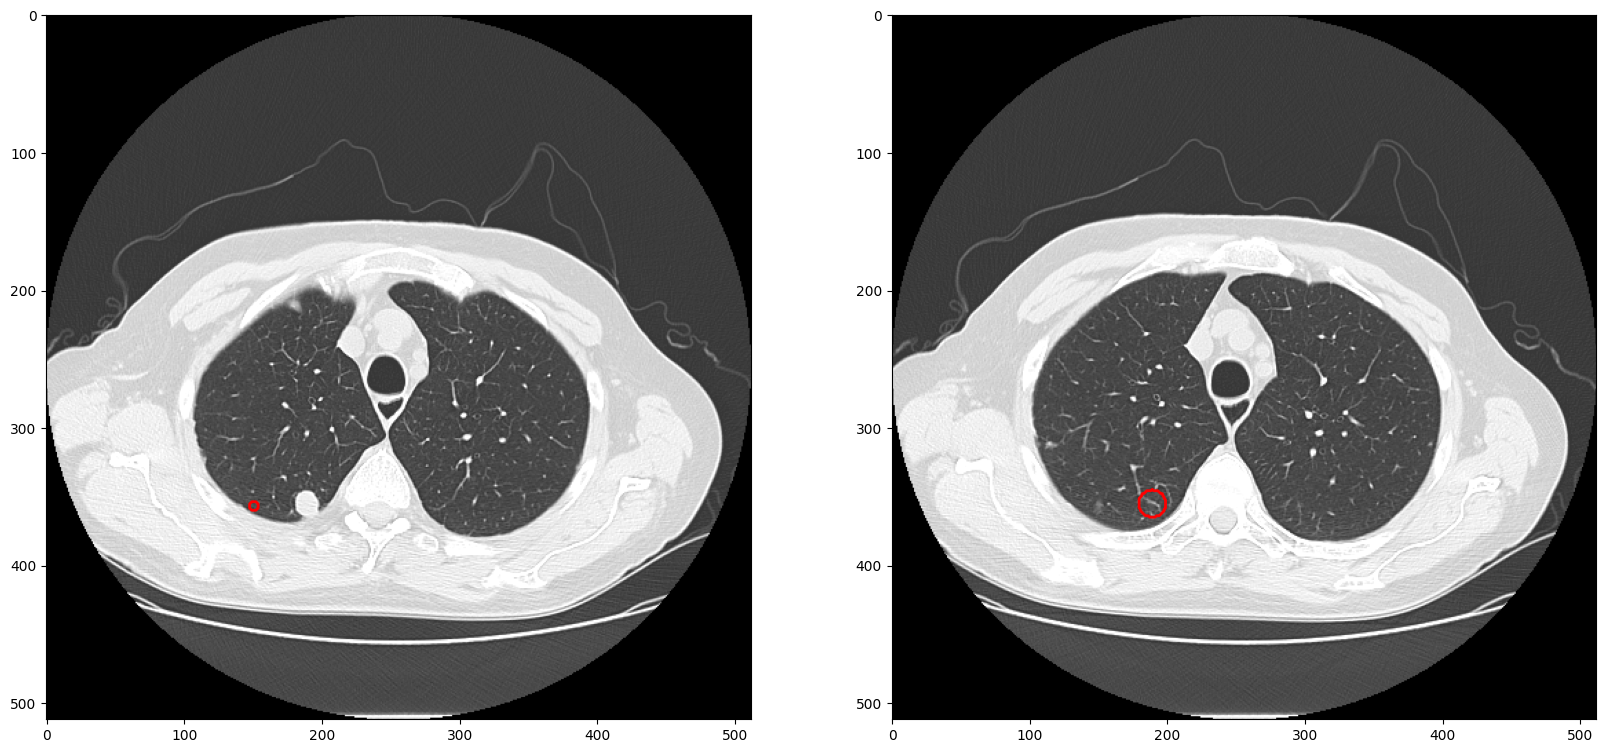

In [21]:
image1 = np.load("D:/fin_de_etude/data/dataset_2d/nodule/image117_slice110.npy")
image2 = np.load("D:/fin_de_etude/data/dataset_2d/nodule/image117_slice107.npy")
mask1 = np.load("D:/fin_de_etude/data/nodule_mask/nodule/image117_slice110.npy")
mask2 = np.load("D:/fin_de_etude/data/nodule_mask/nodule/image117_slice107.npy")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(image1,cmap="gray" )
ax2.imshow(image2,cmap="gray" )
ax2.contour(mask1, levels=[0.4], colors='r', linewidths=2)
ax1.contour(mask2, levels=[0.4], colors='r', linewidths=2)
plt.show()

In [33]:
df = ad.read_csv('D:/fin_de_etude/data/pfe/data preprocessing/annotation_2.csv')
slice = 0
for i in df.index:
    if i == df.index[0] or np.abs(int( df["coordZ"][i]) -int(slice))!=1 and np.abs(int( df["coordZ"][i]) -int(slice))!=2:
            if df["seriesuid"][i][:-2] == "13":
                print(df["seriesuid"][i])
                slice = df["coordZ"][i]
     

13:1
